In [ ]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
from rasterio.mask import mask
from datetime import datetime
import os
import pandas as pd

In [125]:
boundary_path = "../gpkg/cbe_boundary.gpkg"
raster_path = "../tif/20240207T051001_20240207T052026_T43PGN.tif"
places_path = "../gpkg/cbe_places.gpkg"

In [126]:
# Extract the file name
file_name = os.path.basename(raster_path)

# Extract the date string (first 8 characters after 'T' in the file name)
date_str = file_name.split("T")[0]  # "20240207"

# Convert the string to a datetime object for formatting
date_obj = datetime.strptime(date_str, "%Y%m%d")

# Format the date (e.g., "February 7, 2024")
formatted_date = date_obj.strftime("%b, %Y")

print("Extracted Date:", formatted_date)

Extracted Date: Feb, 2024


In [127]:
# Update no data values
# with rasterio.open(raster_path, "r+") as dataset:
#     dataset.nodata = -99

In [128]:
# Read the boundary file
boundary = gpd.read_file(boundary_path)

places = gpd.read_file(places_path)

In [129]:
minx, miny, maxx, maxy = boundary.total_bounds

In [130]:
# Open the raster file
# raster = rasterio.open(raster_path)
# Read the raster
nodata_value = -99
with rasterio.open(raster_path) as src:
    transform = src.transform
    raster_crs = src.crs
    

if raster_crs != boundary.crs:
    boundary = boundary.to_crs(raster_crs)

if raster_crs != places.crs:
    places = places.to_crs(raster_crs)


# Use the boundary to mask and clip the raster
# Extract the boundary geometry
boundary_geom = boundary.geometry.values
with rasterio.open(raster_path) as src:
    # Apply the mask to clip the raster by the boundary
    clipped_data, clipped_transform = mask(src, boundary_geom, crop=True, nodata=-99)
    
masked_data = np.ma.masked_where(clipped_data != 0, clipped_data)

In [131]:
masked_data = masked_data[0]

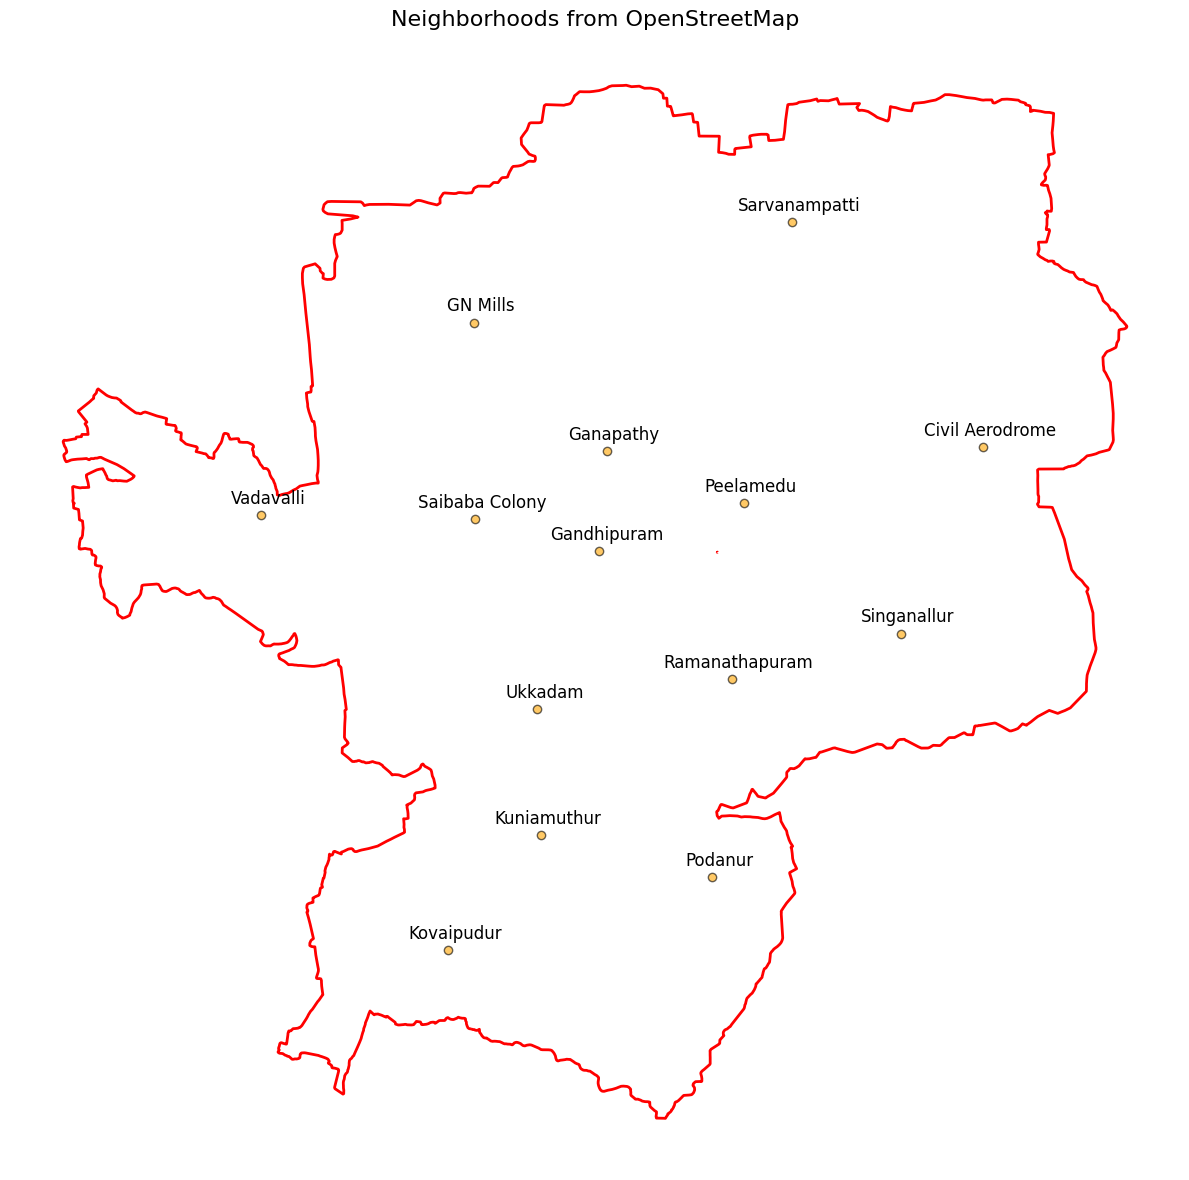

In [132]:

# Plot the results
fig, ax = plt.subplots(figsize=(12, 12))

# Plot neighborhoods
places.plot(ax=ax, color="orange", edgecolor="black", alpha=0.6, label="")

# Plot the boundary
boundary.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2, label="Boundary")

# Add field names as labels for each neighborhood
for _, row in places.iterrows():
    if 'name' in row and pd.notnull(row['name']):
        # Add label with the name field (or adjust to other field if needed)
        ax.text(row.geometry.centroid.x*1.0002, row.geometry.centroid.y*1.0002, row['name'], 
                fontsize=12, ha='center', color='black')


# Add title and legend
ax.set_title("Neighborhoods from OpenStreetMap", fontsize=16)
ax.axis("off")
# ax.legend()

plt.tight_layout()
plt.show()

In [133]:
# # Calculate extent of the raster (to plot correctly)
# # The extent is derived from the affine transform and the shape of the raster
# rows, cols = masked_data.shape
# extent = [transform[2], transform[2] + transform[0] * cols, transform[5] + transform[4] * rows, transform[5]]
# # Plot the masked raster data (built-up areas)
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(masked_data, cmap='coolwarm', extent=extent)
# boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)  # Plot the boundary on top
# ax.set_title("Built-Up Areas")
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# plt.show()

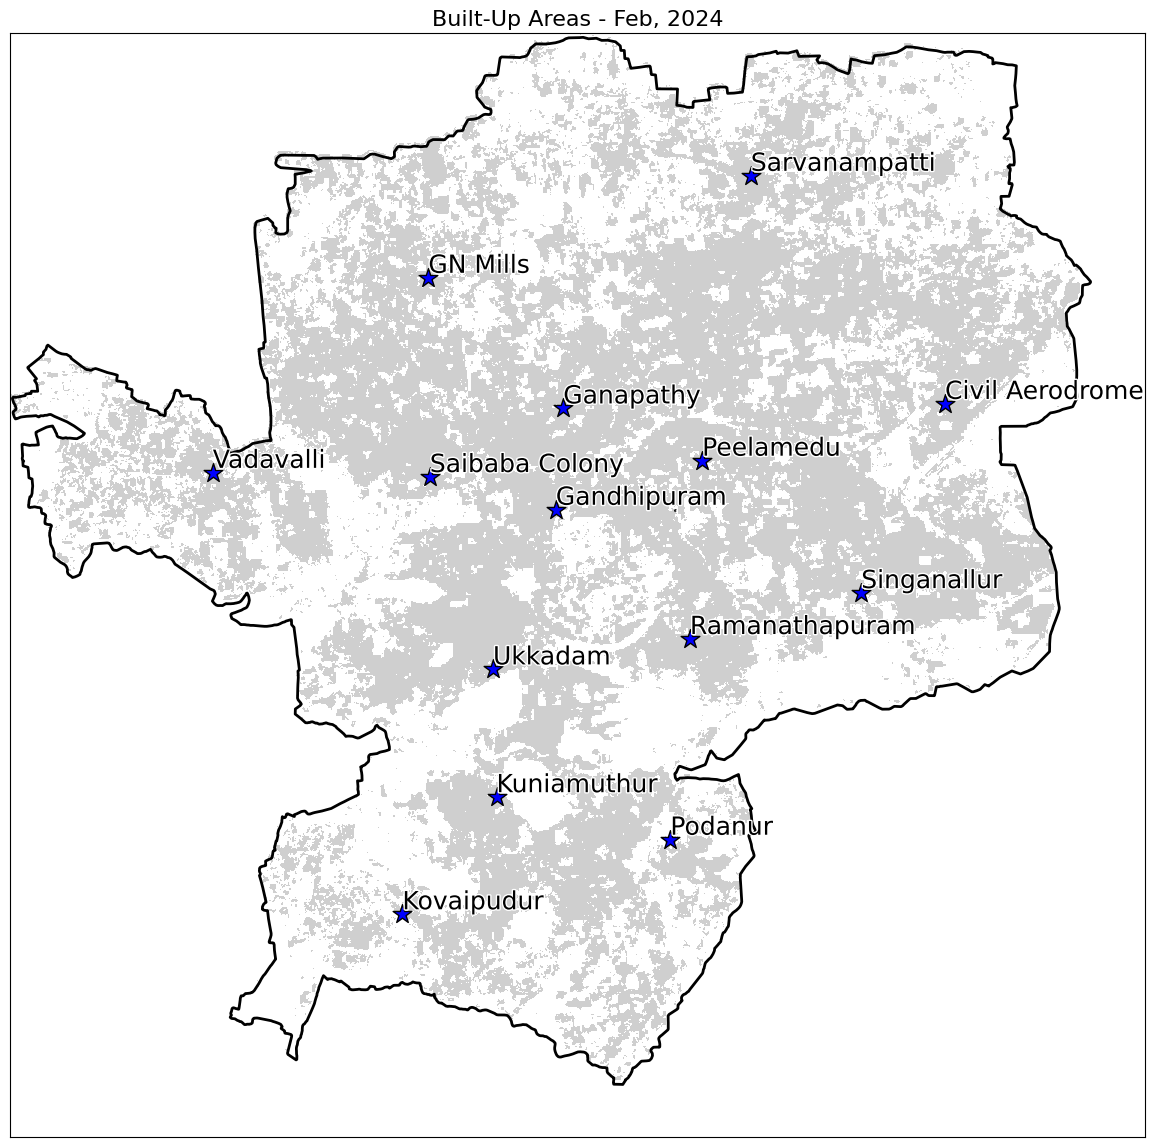

In [179]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a custom colormap (optional, highlights built-up areas better)
built_up_cmap = ListedColormap(['#cfcfcf', '#cfcfcf'])  # Non-built-up as light gray, built-up as brown

# Calculate the extent of the raster
rows, cols = masked_data.shape
extent = [
    transform[2],  # Min Longitude
    transform[2] + transform[0] * cols,  # Max Longitude
    transform[5] + transform[4] * rows,  # Min Latitude
    transform[5],  # Max Latitude
]

# Plot the masked raster data (built-up areas)
fig, ax = plt.subplots(figsize=(12, 12))


# Show raster data with improved colormap and extent
ax.imshow(masked_data, cmap=built_up_cmap, extent=extent, interpolation="nearest")


# Add field names as labels for each neighborhood
for _, row in places.iterrows():
    if 'name' in row and pd.notnull(row['name']):
        # Add label with the name field (or adjust to other field if needed)
        # ax.text(row.geometry.centroid.x*1.0002, row.geometry.centroid.y*1.0002, row['name'], 
        #         fontsize=12, ha='center', color='black')
         ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], 
                fontsize=18, va='bottom', ha='left', color='black',
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# Plot neighborhoods
places.plot(ax=ax, color="blue", edgecolor="black", label="",markersize=200, marker="*")

# Overlay the boundary with transparency and improved styling
boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

# Add title and labels
ax.set_title(f"Built-Up Areas - {formatted_date}", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Add gridlines for better spatial reference
ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)


# Set aspect ratio for better geographic visualization
# ax.set_aspect('equal', 'box')

# Show the plot
plt.tight_layout()
plt.show()
